In [2]:
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from amlta.probas import flows, processes

In [40]:
sns.set_theme(
    context="paper",
    style="ticks",
    palette="colorblind",
    rc={
        "axes.grid": True,
        "axes.grid.which": "both",
        "grid.linestyle": "--",
        "grid.alpha": 0.75,
    },
)

In [5]:
uuids_all = processes.read_uuids(lci_results_only=False)
uuids_lci = processes.read_uuids(lci_results_only=True)

In [6]:
print(len(uuids_lci) / len(uuids_all))

0.507573469123549


In [7]:
lci_processes_gen = processes.ProcessData.from_uuids(uuids_lci)

In [8]:
stats = []

In [9]:
for process in tqdm(lci_processes_gen, total=len(uuids_lci)):
    uuid = process.processInformation.dataSetInformation.UUID
    name = process.processInformation.dataSetInformation.name.baseName.get()
    if synonyms := process.processInformation.dataSetInformation.synonyms:
        synonyms = synonyms.get()

    class_levels = {}

    classes = process.processInformation.dataSetInformation.classificationInformation.classification
    if classes:
        for item in classes:
            for class_item in item.class_:
                class_levels[f"class_level_{class_item.level}"] = class_item.value

    process_flows = flows.extract_process_flows(process)

    input_flows = len(process_flows.loc[process_flows["exchange_direction"] == "INPUT"])
    output_flows = len(
        process_flows.loc[process_flows["exchange_direction"] == "OUTPUT"]
    )

    main_output_exchange = process.get_main_output()
    if main_output_exchange:
        main_flow_uuid = main_output_exchange.referenceToFlowDataSet.refObjectId
        main_flow_name = process_flows.loc[
            process_flows["flow_uuid"] == main_flow_uuid, "flow_description"
        ].values[0]
    else:
        main_flow_uuid = None
        main_flow_name = None

    geography = process.processInformation.geography.locationOfOperationSupplyOrProduction.location
    year = process.processInformation.time.referenceYear
    year_until = process.processInformation.time.dataSetValidUntil

    stats.append(
        {
            "uuid": uuid,
            "name": name,
            "synonyms": synonyms,
            **class_levels,
            "input_flows": input_flows,
            "output_flows": output_flows,
            "main_flow_uuid": main_flow_uuid,
            "main_flow_name": main_flow_name,
            "geography": geography,
            "year": year,
            "year_until": year_until,
        }
    )

  0%|          | 0/11762 [00:00<?, ?it/s]

In [10]:
process_df = pd.DataFrame(stats)

In [11]:
class_level_columns = [
    col for col in process_df.columns if col.startswith("class_level_")
]
other_columns = [
    col for col in process_df.columns if not col.startswith("class_level_")
]

process_df = process_df[
    other_columns[:3] + sorted(class_level_columns) + other_columns[3:]
]

In [30]:
process_df

,uuid,name,synonyms,class_level_0,class_level_1,class_level_2,class_level_3,class_level_4,class_level_5,input_flows,output_flows,main_flow_uuid,main_flow_name,geography,year,year_until
0,9db4c992-9281-466c-8adc-eb1daddda800,Gas-HKW-GuD-gross-DK-2015-th/en,None,Energieversorgung,Fernwärmeversorgung,NaN,NaN,NaN,NaN,21,60,0e0b24c6-9043-11d3-b2c8-0080c8941b49,warm water,DK,2015,NaN
1,50e9e77d-f431-4e05-82d8-ccf3de8ff1c9,Gas-Heizung-SK-2020,None,Verbrauch-Haushalte,NaN,NaN,NaN,NaN,NaN,21,60,0e0b2461-9043-11d3-b2c8-0080c8941b49,space heat,SK,2020,NaN
2,d29b4a91-90ec-44e0-a8b0-148d57fb0889,Xtra-onshore\Gas-RU-2015,None,"Gewinnung von Erdöl und Erdgas, Erbringung dam...",Gewinnung von Erdöl und Erdgas,NaN,NaN,NaN,NaN,21,60,0e0b2378-9043-11d3-b2c8-0080c8941b49,natural gas-RU,RU,2015,NaN
3,b5703309-67df-4ff2-84ee-f55ff80f7604,Verdichter-GT-DK-2020,None,Energieversorgung,Gasversorgung,Gasverteilung und -handel durch Rohrleitungen,NaN,NaN,NaN,21,60,b11c62e8-a5b4-11d3-b42d-fed95173dc12,mechanical-energy,DK,2020,NaN
4,0fdc211d-4815-4f9d-81b9-dc3cb6f08036,Xtra-mix\Uran-ZA-2000,None,Bergbau auf Uran- und Thoriumerze,NaN,NaN,NaN,NaN,NaN,20,60,0e0b24bd-9043-11d3-b2c8-0080c8941b49,uranium,ZA,2000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11757,64682f46-8eca-4038-87ab-19c4e9dfcd5a,Pipeline\Biomethan-Mais-iLUC50% (Acker)-DE-2030,None,Energieversorgung,Gasversorgung,Gasverteilung und -handel durch Rohrleitungen,NaN,NaN,NaN,21,60,22f1eb67-0337-40a2-a42d-ca2cf3318da5,biogas-processed-for-gas-pipeline,DE,2030,NaN
11758,a6a4718a-9ffc-440c-a8cf-8bf294d54b18,Gas-mix-BR-2020,None,Energieversorgung,Gasversorgung,NaN,NaN,NaN,NaN,21,49,cc0e4887-80da-11d4-9e81-0080c8426c9a,gas-from-lignite-CZ,BR,2020,NaN
11759,2cc29c94-8b87-44a7-a92e-1c7b3455367f,Biogas-Mais-dLUC (Grünland)-BHKW-500 kW DE-201...,None,Energieversorgung,Elektrizitätsversorgung,Elektrizitätserzeugung,NaN,NaN,NaN,21,60,0e0b235d-9043-11d3-b2c8-0080c8941b49,electricity,DE,2010,NaN
11760,95d344c7-7974-4060-9ccc-0b26b19f18a0,Pipeline\Gas-UA-2005,None,Energieversorgung,Gasversorgung,Gasverteilung und -handel durch Rohrleitungen,NaN,NaN,NaN,21,60,b993e9b1-d7c1-4638-8e0d-94dceeabf028,natural gas-UA,UA,2005,NaN


In [19]:
def get_label(row):
    l1 = row["class_level_1"]
    if pd.isna(l1):
        l1 = row["class_level_0"]

    if pd.isna(l1):
        return l1
    else:
        return l1[:25] + "..." if len(l1) > 25 else l1


level_1_labels = process_df.apply(get_label, axis=1)
# ["class_level_1"].map(
#     lambda s: (s[:25] + "...") if not pd.isna(s) and len(s) > 26 else s
# )

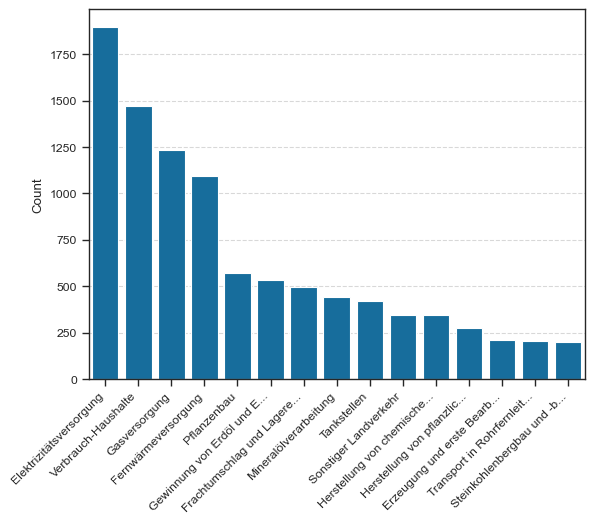

In [41]:
ax = sns.barplot(
    data=level_1_labels.value_counts().iloc[:15],  # type: ignore
)

ax.set_xlabel("")
ax.set_ylabel("Count")

ax.set_xticks(range(len(ax.get_xticklabels())))
ax.tick_params(axis="x", labelrotation=45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

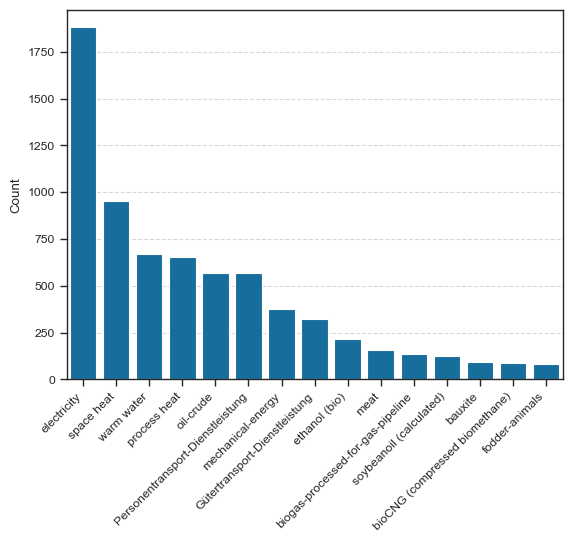

In [105]:
ax = sns.barplot(
    process_df["main_flow_name"].value_counts().iloc[:15]  # type: ignore
)

ax.set_xlabel("")
ax.set_ylabel("Count")

ax.set_xticks(range(len(ax.get_xticklabels())))
ax.tick_params(axis="x", labelrotation=45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

In [111]:
display(process_df["input_flows"].describe())
display(process_df["output_flows"].describe())

count    11762.000000
mean        21.566060
std         12.100946
min          1.000000
25%         21.000000
50%         21.000000
75%         21.000000
max        114.000000
Name: input_flows, dtype: float64

count    11762.000000
mean        83.633991
std        203.953048
min         45.000000
25%         60.000000
50%         60.000000
75%         60.000000
max       1702.000000
Name: output_flows, dtype: float64

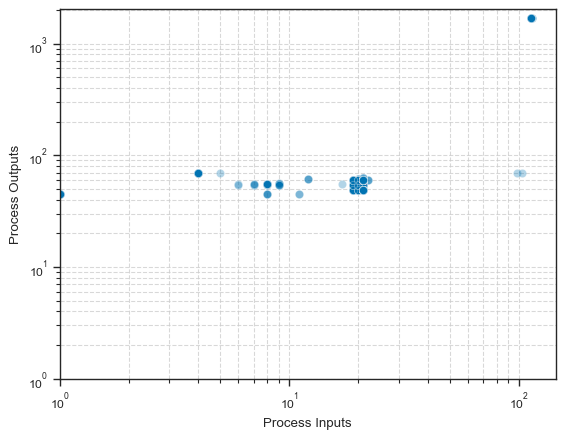

In [110]:
ax = sns.scatterplot(
    data=process_df,
    x="input_flows",
    y="output_flows",
    alpha=0.3,
    s=35,
)

ax.set_xlabel("Process Inputs")
ax.set_ylabel("Process Outputs")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(xmin=1)
ax.set_ylim(ymin=1);

In [99]:
process_df["geography"].value_counts().to_frame().iloc[:15]

,count
geography,
DE,4716
RER,1100
BR,327
RU,253
US,220
AU,208
ID,203
PL,197
CA,196
